#### A quick demonstration of imaginary lensing reconstruction in fullsky

In [1]:
import numpy as np, basic, curvedsky as cs, plottools as pl, healpy as hp, binning as bn, cmb
from matplotlib.pyplot import *

In [2]:
def sim(lmax,rlmin,rlmax,lcl,Ag,nl):
    # gaussian alms are generated, and the reconstructed cls are equal to the normalization
    Talm, Ealm, Balm = cs.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
    # add noise and filtering (temp)
    Talm += cs.utils.gauss1alm(lmax,nl[0,:])
    Ealm += cs.utils.gauss1alm(lmax,nl[1,:])
    Balm += cs.utils.gauss1alm(lmax,nl[2,:])
    # simple diagonal c-inverse
    Fl = np.zeros((3,lmax+1,lmax+1))
    for l in range(rlmin,rlmax):
        Fl[:,l,0:l+1] = 1./ocl[:3,l,None]
    Talm *= Fl[0,:,:]
    Ealm *= Fl[1,:,:]
    Balm *= Fl[2,:,:]
    # compute unnormalized estiamtors
    glm, clm = {}, {}
    #glm['TE'] = cs.rec_iamp.qte(lmax,rlmin,rlmax,lcl[3,:],Talm,Ealm)
    #glm['TB'] = cs.rec_iamp.qtb(lmax,rlmin,rlmax,lcl[3,:],Talm,Balm)
    #glm['EE'] = cs.rec_iamp.qee(lmax,rlmin,rlmax,lcl[1,:],Ealm,Ealm)
    glm['EB'] = cs.rec_iamp.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)
    #glm['BB'] = cs.rec_iamp.qbb(lmax,rlmin,rlmax,lcl[1,:],Balm,Balm)
    # compute auto and cross spectra
    gl = {}
    #for qest in ['TE','TB','EE','EB','BB']:
    for qest in ['EB']:
        gl[qest] = cs.utils.alm2cl(lmax,Ag[qest][:,None]*glm[qest])
    return gl['EB']
    #return gl['TE'], gl['TB'], gl['EE'], gl['EB'], gl['BB'], cl['TE'], cl['TB'], cl['EE'], cl['EB'], cl['BB']

In [3]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2000       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 10.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)
# for sim
simn = 1

In [4]:
#quad = ['TE','TB','EE','EB','BB']
quad = ['EB']
#color = ['c','m','g','b','y']
color = ['m']

#### Load unlensed and lensed Cls

In [5]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

#### Calculate normalizations

In [6]:
Ag = {}
#Ag['TE'] = cs.norm_imag.qte(rlmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[1,:])[0]
#Ag['TB'] = cs.norm_imag.qtb(rlmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[2,:])[0]
#Ag['EE'] = cs.norm_imag.qee(rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:])[0]
Ag['EB'] = cs.norm_imag.qeb('amp',rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])[0]
#Ag['BB'] = cs.norm_imag.qbb(rlmax,rlmin,rlmax,lcl[1,:],ocl[2,:])[0]

#### Running simulation

In [7]:
cl = np.zeros((simn,1,lmax+1))
for i in range(simn):
    print(i)
    cl[i,:,:] = sim(lmax,rlmin,rlmax,lcl,Ag,nl)

0


In [8]:
mb = bn.multipole_binning(20,lmax=lmax)
cls = bn.binning(cl,mb)
mgl = np.mean(cls,axis=0)
vgl = np.std(cls,axis=0)

In [9]:
cli = np.mean(cl,axis=0)

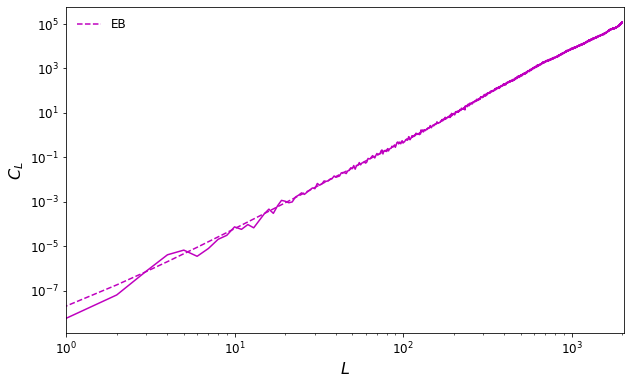

In [10]:
s = (L*(L+1))**2/2/np.pi
pl.plot_1dstyle(fsize=[10,6],xmin=1,xmax=2048,xlog=True,ylog=True)
for qi, (q,c) in enumerate(zip(quad,color)):
#for qi, q in enumerate(['EB']):
    plot(s*Ag[q],label=q,color=c,ls='--')
    plot(s*cli[qi],color=c,ls='-')
#plot(cl[q],label=q)
    #errorbar(mb.bc-5,mgl[qi,:],yerr=vgl[qi,:],fmt='o',label=q)
axhline(0,color='k',ls='--')
legend()